## Collaborative Recommender 
based on user behaviour 

**** https://www.kaggle.com/zolboo/recommender-systems-knn-svd-nn-keras/notebook

Use implicit package for python
https://implicit.readthedocs.io/en/latest/models.html

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [239]:
df1 = pd.read_csv('data/users_projects_0-100.csv')
df2 = pd.read_csv('data/users_projects_100-300.csv')
df3 = pd.read_csv('data/users_projects_300-500.csv')
df4 = pd.read_csv('data/users_projects_500-700.csv')
df5 = pd.read_csv('data/users_projects_700-900.csv')
df6 = pd.read_csv('data/users_projects_900-1100.csv')
df7 = pd.read_csv('data/users_projects_1100-1300.csv')
df8 = pd.read_csv('data/users_projects_1300-1500.csv')
df9 = pd.read_csv('data/users_projects_1500-1700.csv')# this one will need to be redone
df10 = pd.read_csv('data/users_projects_1700-1900.csv')
df11 = pd.read_csv('data/users_projects_1887-1900.csv')
df12 = pd.read_csv('data/users_projects_1900-2100.csv')
df13 = pd.read_csv('data/users_projects_2100-2300.csv')
df14 = pd.read_csv('data/users_projects_2300-2500.csv')
df15 = pd.read_csv('data/users_projects_2500-2700.csv')
df16 = pd.read_csv('data/users_projects_2700-2900.csv')
df17 = pd.read_csv('data/users_projects_2900-2962.csv')

pattern_details = pd.read_csv('data/consolidated_patterns.csv', low_memory=False)
# this needs to be repaced with cleaned data?

In [240]:
(df1.shape, df2.shape, df3.shape, df4.shape, 
 df5.shape, df6.shape, df7.shape, df8.shape,
 df9.shape, df10.shape, df11.shape,df12.shape,
 df13.shape, df14.shape, df15.shape,df16.shape, df17.shape
)

((343032, 4),
 (386356, 4),
 (248913, 4),
 (210382, 4),
 (171374, 4),
 (161808, 4),
 (281092, 4),
 (279575, 4),
 (596740, 4),
 (813227, 4),
 (35527, 4),
 (366425, 4),
 (298682, 4),
 (252212, 4),
 (220635, 4),
 (185410, 4),
 (44375, 4))

In [241]:
# For full set
df = df1.append(df2, ignore_index=True)
df = df.append(df3, ignore_index=True)
df = df.append(df4, ignore_index=True)
df = df.append(df5, ignore_index=True)
df = df.append(df6, ignore_index=True)
df = df.append(df7, ignore_index=True)
df = df.append(df8, ignore_index=True)
df = df.append(df9, ignore_index=True)
df = df.append(df10, ignore_index=True)
df = df.append(df11, ignore_index=True)
df = df.append(df12, ignore_index=True)
df = df.append(df13, ignore_index=True)
df = df.append(df14, ignore_index=True)
df = df.append(df15, ignore_index=True)
df = df.append(df16, ignore_index=True)
df = df.append(df17, ignore_index=True)
df.shape

(4895765, 4)

In [ ]:
# # use these plots from https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
# # Number of ratings per user
# data = df.groupby('userID')['bookRating'].count().clip(upper=50)

# # Create trace
# trace = go.Histogram(x = data.values,
#                      name = 'Ratings',
#                      xbins = dict(start = 0,
#                                   end = 50,
#                                   size = 2))
# # Create layout
# layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
#                    xaxis = dict(title = 'Ratings Per User'),
#                    yaxis = dict(title = 'Count'),
#                    bargap = 0.2)

# # Create plot
# fig = go.Figure(data=[trace], layout=layout)
# iplot(fig)

In [242]:
# Clean data and save

# remove accidental headers
df = df.drop(df[df['user_id']=='user_id'].index)

# remove douplicates
df = df.drop_duplicates()

# reset index
df.reset_index(inplace=True, drop=True)

# df.to_csv('data/user_projects_cleaned.csv', index=False)

In [243]:
df.shape

(4478010, 4)

In [244]:
# add 'has_knit' column is place of rating (using implicit rather than explicit rating)
df['has_knit'] = 1
print(df.shape)
df.head()

# rename uid and iid as per utility matrix

(4478010, 5)


,user_id,pattern_ids,date_completed,project_id,has_knit
0,5153610,88,2021/11/19,29203938,1
1,3183664,88,2021/11/18,29195691,1
2,3183664,88,2021/11/17,29190583,1
3,2102666,88,2021/11/17,29177512,1
4,3183664,88,2021/11/16,29187197,1


In [ ]:
# drop douplicate knits per pattern
df = df.drop_duplicates(['user_id', 'pattern_ids'])
df.shape

(3250978, 5)

In [ ]:
# how many users, how many patterns?
pattern_count_per_user = df.groupby("user_id", as_index=False).count().sort_values('has_knit', ascending = False)
pattern_count_per_user

# uh oh - how many are 0?


,user_id,pattern_ids,date_completed,project_id,has_knit
61820,17244,302,298,302,302
273983,698879,261,254,261,261
253153,616629,260,258,260,260
296299,79380,256,105,256,256
111658,24654,239,229,239,239
...,...,...,...,...,...
254489,6218491,1,1,1,1
254488,6218465,1,1,1,1
160108,342361,1,0,1,1
85382,204944,1,1,1,1


In [ ]:
pattern_count_per_user.describe()

,pattern_ids,date_completed,project_id,has_knit
count,345059.000000,345059.000000,345059.000000,345059.000000
mean,12.977520,10.615164,12.977520,12.977520
std,22.736905,21.070589,22.736905,22.736905
min,1.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000
50%,4.000000,3.000000,4.000000,4.000000
75%,14.000000,11.000000,14.000000,14.000000
max,720.000000,720.000000,720.000000,720.000000


In [ ]:
# AND LOOK AT THIS  _ ALSO FROM WALKTHROUGH!
# # from article - ensure statiscical significance, users less than 200 ratings and books less than 100 ratings excluede
# counts1 = book_ratings['User-ID'].value_counts()
# book_ratings = book_ratings[book_ratings['User-ID'].isin(counts1[counts1 >= 200].index)]
# counts = book_ratings['Book-Rating'].value_counts()
# book_ratings = book_ratings[book_ratings['Book-Rating'].isin(counts[counts >= 100].index)]

In [ ]:
# # OR TRY THIS FROM MEMORY WALKTRHOUGH 
# import matplotlib.pyplot as plt
# print(book_ratings.shape)
# print(list(book_ratings.columns))
# plt.rc("font", size=15)
# book_ratings['Book-Rating'].value_counts(sort=False).plot(kind='bar')
# plt.title('Rating Distribution\n')
# plt.xlabel('Rating')
# plt.ylabel('Count')
# plt.savefig('system1.png', bbox_inches='tight')
# plt.show()
# print(books.shape)
# print(list(books.columns))

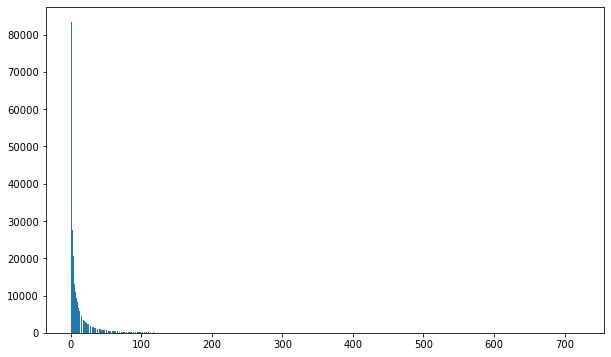

In [247]:
y = pattern_count_per_user['pattern_ids']
fig, ax = plt.subplots(figsize = (10,6))

# histogram
ax.hist(y,bins=1000)
plt.show()

In [266]:
pattern_count_per_user_gt_40 = pattern_count_per_user[pattern_count_per_user['pattern_ids'] >40]
# pattern_count_per_user.shape
indices_to_drop = pattern_count_per_user[pattern_count_per_user['pattern_ids'] <=40].index.to_list()
len(indices_to_drop)

323603

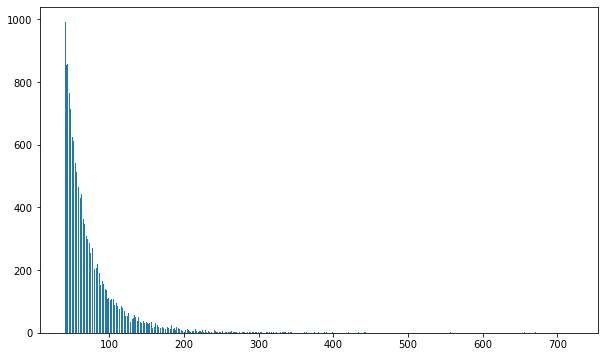

In [256]:
y = pattern_count_per_user_gt_40['pattern_ids']
fig, ax = plt.subplots(figsize = (10,6))

# histogram
ax.hist(y,bins=1000)
plt.show()

In [257]:

df = df[~df.index.isin(indices_to_drop)]
# merge metadata
df.shape

(3250978, 5)

In [265]:
pattern_count_per_user_gt_40.describe()

,pattern_ids,date_completed,project_id,has_knit
count,27661.000000,27661.000000,27661.000000,27661.000000
mean,73.736416,65.853368,73.736416,73.736416
std,39.116392,38.951095,39.116392,39.116392
min,41.000000,0.000000,41.000000,41.000000
25%,49.000000,43.000000,49.000000,49.000000
50%,61.000000,55.000000,61.000000,61.000000
75%,84.000000,77.000000,84.000000,84.000000
max,720.000000,720.000000,720.000000,720.000000


In [258]:
df.pattern_ids.values

array(['88', '88', '88', ..., '449489', '449489', '449489'], dtype=object)

In [260]:
# In order to pull out pattern details after we get similar patterns, need the metadata 
#(merge df with pattern_details)

metadata = pattern_details[pattern_details['pattern_id'].isin(df.pattern_ids.values)]
# REINDEX??
print(metadata.shape)
metadata.head()

(2963, 24)


,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,...,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
0,88,Calorimetry,calorimetry,29838,19426,1.816424,7294.0,4.225295,7895,6618.0,...,"['unisex', 'teen', 'adult', 'fitted', 'reversi...",NaN,93.0,2006/12/01 00:00:00 -0500,20.0,4.0,True,True,"['headband', 'headwear', 'accessories']",Aran (8 wpi)
1,3156,Basic Ribbed Socks,basic-ribbed-socks,17795,10987,2.435581,2670.0,4.455242,3519,2480.0,...,"['unisex', 'adult', 'top-cuff-down', 'heel-fla...",NaN,370.0,2006/04/01 00:00:00 -0500,32.0,4.0,True,True,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
2,3636,"#29 Classic Socks- baby, child & adult socks",29-classic-socks--baby-child--adult-socks,3483,6019,2.851249,921.0,4.493304,463,896.0,...,"['unisex', 'baby', 'toddler', 'child', 'teen',...",NaN,NaN,2007/05/18 07:01:30 -0400,NaN,1.0,False,True,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Sport (12 wpi)
3,27077,Jacques Cousteau Hat,jacques-cousteau-hat,22539,7325,1.865684,2442.0,4.267587,4534,2246.0,...,"['male', 'ribbed', 'written-pattern', 'in-the-...",234.0,234.0,2006/03/01 00:00:00 -0500,22.0,4.0,True,True,"['beanie-toque', 'hat', 'accessories']",DK (11 wpi)
4,29869,Sock Patterns for Regia 4ply,sock-patterns-for-regia-4ply,1190,2469,2.853333,300.0,4.223776,219,286.0,...,"['unisex', 'adult', 'top-cuff-down', 'heel-fla...",NaN,460.0,2007/10/27 18:20:38 -0400,30.0,4.0,False,False,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)


#### Check Sparsity

In [314]:
n_users = df.user_id.unique().shape[0]
n_items = df.pattern_ids.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(df.shape[0]) / float(n_users*n_items) * 100))

# Woot - this is above the 0.1 percent threshold - performance generally degrades the more sparse the matrix is 

Number of users: 338751
Number of models: 2961
Sparsity: 0.324%


### Unique counts

In [ ]:
# print('No. of Unique Users    :', reviews.userID.nunique())
# print('No. of Unique Business :', reviews.businessID.nunique())
# print('No. of Unique Ratings  :', reviews.rating.nunique())


# look here for bar charts I should include here too
# https://bmanohar16.github.io/blog/recsys-evaluation-in-surprise

In [315]:
df.shape

(3250978, 5)

In [68]:
# user_project_map = df.pivot_table(index='user_id', columns='pattern_ids', values='has_knit')
# user_project_map.head()                    
# user_project_map.shape
# # user_project_map.head()

(290270, 1700)

In [385]:
df.to_csv('data/less_sparse_users_patterns.csv', index=False)